# Calculate Time Averages from Time Series Data

Author: [Tom Vo](https://github.com/tomvothecoder/) & [Jiwoo Lee](https://github.com/lee1043/)

Updated: 03/17/25 [xcdat v0.8.0]

Related APIs:

- [xarray.Dataset.temporal.average()](../generated/xarray.Dataset.temporal.average.rst)
- [xarray.Dataset.temporal.group_average()](../generated/xarray.Dataset.temporal.group_average.rst)


## Overview

Suppose we have netCDF4 files for air temperature data (`tas`) with monthly, daily, and 3hr frequencies.

We want to calculate averages using these files with the time dimension removed (a single time snapshot), and averages by time group (yearly, seasonal, and daily).

The data used in this example can be found in the [xcdat-data repository](https://github.com/xCDAT/xcdat-data).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook -c conda-forge xcdat xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter pooch
```

Then install the kernel from the `xcdat_notebook` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook`):

```bash
python -m ipykernel install --user --name xcdat_notebook --display-name xcdat_notebook
```

Then to select the kernel `xcdat_notebook` in Jupyter to use this kernel.


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xcdat as xc


/opt/miniconda3/envs/xcdat_notebook/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


## 1. Calculate averages with the time dimension removed (single snapshot)

Related API: [xarray.Dataset.temporal.average()](../generated/xarray.Dataset.temporal.average.rst)

Helpful knowledge:

- The frequency for the time interval is inferred before calculating weights.

  - The frequency is inferred by calculating the minimum delta between time coordinates and using the conditional logic below. This frequency is used to calculate weights.

- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data are excluded when averages are calculated. This is the same as giving them a weight of 0.


### Open the `Dataset`

In this example, we will be calculating the time weighted averages with the time dimension removed (single snapshot) for monthly `tas` data.

We are using xarray's OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

_More information on the xarray's OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap)._


In [2]:
ds = xc.tutorial.open_dataset("tas_amon_access")

# Unit adjust (-273.15, K to C)
ds["tas"] = ds.tas - 273.15

ds

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 60, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B 2.0
  * time       (time) object 480B 1870-01-16 12:00:00 ... 1874-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 960B ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 7MB -29.36 -29.36 ... -31.07 -31.07
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
ds_avg = ds.temporal.average("tas", weighted=True)

In [4]:
ds_avg.tas

<xarray.DataArray 'tas' (lat: 145, lon: 192)> Size: 223kB
array([[-48.33789281, -48.33789281, -48.33789281, ..., -48.33789281,
        -48.33789281, -48.33789281],
       [-45.11841101, -45.15598013, -45.19300779, ..., -45.00752255,
        -45.04406075, -45.08005955],
       [-44.16135662, -44.27207786, -44.3812548 , ..., -43.8142947 ,
        -43.93083878, -44.04664427],
       ...,
       [-18.87074617, -18.84301489, -18.81438219, ..., -18.96065605,
        -18.92790196, -18.89991471],
       [-18.98835924, -18.97666923, -18.96525417, ..., -19.02792192,
        -19.01732752, -19.00373892],
       [-19.36861239, -19.36861239, -19.36861239, ..., -19.36861239,
        -19.36861239, -19.36861239]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
Attributes:
    operation:  temporal_avg
    mode:       average
    freq:       month
    weighted:   True

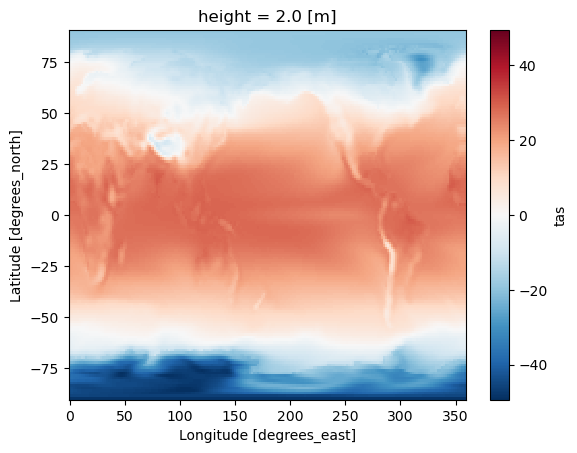

In [5]:
ds_avg.tas.plot(label="weighted")

## 2. Calculate grouped averages

Related API: [xarray.Dataset.temporal.group_average()](../generated/xarray.Dataset.temporal.group_average.rst)

Helpful knowledge:

- Each specified frequency has predefined groups for grouping time coordinates.

  - The table below maps type of averages with its API frequency and grouping convention.

    | Type of Averages | API Frequency                                                            | Group By               |
    | ---------------- | ------------------------------------------------------------------------ | ---------------------- |
    | Yearly           | `freq=“year”`                                                            | year                   |
    | Monthly          | `freq=“month”`                                                           | year, month            |
    | Seasonal         | `freq=“season”`                                                          | year, season           |
    | Custom seasonal  | `freq="season"` and </br> `season_config={"custom_seasons": <2D ARRAY>}` | year, season           |
    | Daily            | `freq=“day”`                                                             | year, month, day       |
    | Hourly           | `freq=“hour”`                                                            | year, month, day, hour |

  - The grouping conventions are based on [CDAT/cdutil](https://github.com/CDAT/cdutil/blob/b823b69db46bb76536db7d435e72075fc3975c65/cdutil/times.py#L1620-L1640), except for daily and hourly means which aren't implemented in CDAT/cdutil.

- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data are excluded when averages are calculated. This is the same as giving them a weight of 0.


### Open the `Dataset`

In this example, we will be calculating the weighted grouped time averages for `tas` data.


In [6]:
ds = xc.tutorial.open_dataset("tas_amon_access")

# Unit adjust (-273.15, K to C)
ds["tas"] = ds.tas - 273.15

ds

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 60, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B 2.0
  * time       (time) object 480B 1870-01-16 12:00:00 ... 1874-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 960B ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 7MB -29.36 -29.36 ... -31.07 -31.07
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

### Yearly Averages

**Group time coordinates by year**


In [7]:
ds_yearly = ds.temporal.group_average("tas", freq="year", weighted=True)

In [8]:
ds_yearly.tas

<xarray.DataArray 'tas' (time: 5, lat: 145, lon: 192)> Size: 1MB
array([[[-48.00315094, -48.00315094, -48.00315094, ..., -48.00315094,
         -48.00315094, -48.00315094],
        [-44.72550583, -44.76009369, -44.7939682 , ..., -44.61826324,
         -44.65423203, -44.68859482],
        [-43.70149612, -43.81060028, -43.91539764, ..., -43.35164261,
         -43.47028351, -43.5880928 ],
        ...,
        [-19.03745079, -19.02015114, -19.00566483, ..., -19.08402443,
         -19.06647491, -19.05134201],
        [-18.88141251, -18.87713432, -18.87248802, ..., -18.90729904,
         -18.89969826, -18.88942337],
        [-19.12470627, -19.12470627, -19.12470627, ..., -19.12470627,
         -19.12470627, -19.12470627]],

       [[-48.26286697, -48.26286697, -48.26286697, ..., -48.26286697,
         -48.26286697, -48.26286697],
        [-45.24733734, -45.28610992, -45.32476425, ..., -45.13527679,
         -45.17295837, -45.2094574 ],
        [-44.31511307, -44.43467712, -44.55186462, ..., -43.93939972,
         -44.06338501, -44.18948746],
...
        [-18.86214447, -18.83517456, -18.80387878, ..., -18.94879341,
         -18.91693497, -18.89120865],
        [-18.91459274, -18.90530014, -18.90104485, ..., -18.95430374,
         -18.94831467, -18.93440056],
        [-19.18630219, -19.18630219, -19.18630219, ..., -19.18630219,
         -19.18630219, -19.18630219]],

       [[-48.77809906, -48.77809906, -48.77809906, ..., -48.77809906,
         -48.77809906, -48.77809906],
        [-45.70363998, -45.74721909, -45.78779984, ..., -45.5719223 ,
         -45.6156311 , -45.65782928],
        [-44.98069382, -45.09814835, -45.21481705, ..., -44.61886597,
         -44.74005508, -44.86090088],
        ...,
        [-18.30337334, -18.25943947, -18.21505547, ..., -18.4534111 ,
         -18.39937019, -18.35258865],
        [-18.56785965, -18.54891014, -18.52729797, ..., -18.63190651,
         -18.61323357, -18.59050751],
        [-19.06952477, -19.06952477, -19.06952477, ..., -19.06952477,
         -19.06952477, -19.06952477]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 40B 1870-01-01 00:00:00 ... 1874-01-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       group_average
    freq:       year
    weighted:   True

![tas yearly averages](../examples/temporal-average-yearly.gif)

_This GIF was created using [xmovie](https://github.com/jbusecke/xmovie)._

Sample `xmovie` code:

```python
import xmovie
mov = xmovie.Movie(ds_yearly_avg.tas)
mov.save("temporal-average-yearly.gif")
```


### Seasonal Averages

**Group time coordinates by year and season**


In [9]:
ds_season = ds.temporal.group_average("tas", freq="season", weighted=True)

In [10]:
ds_season.tas

<xarray.DataArray 'tas' (time: 21, lat: 145, lon: 192)> Size: 5MB
array([[[-33.82228088, -33.82228088, -33.82228088, ..., -33.82228088,
         -33.82228088, -33.82228088],
        [-32.29315948, -32.32157135, -32.35351562, ..., -32.20928192,
         -32.23791122, -32.26279449],
        [-31.53093338, -31.63515091, -31.74136925, ..., -31.21786118,
         -31.31824875, -31.42560577],
        ...,
        [-36.58424377, -36.55802155, -36.52974701, ..., -36.66168213,
         -36.61999512, -36.60799408],
        [-36.1302948 , -36.12440491, -36.1185379 , ..., -36.18497849,
         -36.17271805, -36.14826965],
        [-36.16952133, -36.16952133, -36.16952133, ..., -36.16952133,
         -36.16952133, -36.16952133]],

       [[-54.28203583, -54.28203583, -54.28203583, ..., -54.28203583,
         -54.28203583, -54.28203583],
        [-50.24617386, -50.29518127, -50.34090424, ..., -50.10178375,
         -50.15110397, -50.19815063],
        [-48.90485764, -49.03684235, -49.16397858, ..., -48.50334167,
         -48.63829803, -48.77178192],
...
        [-16.03623962, -15.98614311, -15.93428612, ..., -16.20112801,
         -16.1357193 , -16.08994293],
        [-16.44024467, -16.42702866, -16.40401077, ..., -16.51081276,
         -16.49159622, -16.46790504],
        [-17.08136368, -17.08136368, -17.08136368, ..., -17.08136368,
         -17.08136368, -17.08136368]],

       [[-29.95863342, -29.95863342, -29.95863342, ..., -29.95863342,
         -29.95863342, -29.95863342],
        [-28.73851013, -28.77604675, -28.81460571, ..., -28.62869263,
         -28.66233826, -28.69960022],
        [-28.04180908, -28.16485596, -28.28715515, ..., -27.68370056,
         -27.79893494, -27.91860962],
        ...,
        [-29.49139404, -29.39035034, -29.28747559, ..., -29.81793213,
         -29.70074463, -29.59967041],
        [-30.09056091, -30.03196716, -29.9712677 , ..., -30.30175781,
         -30.24359131, -30.15879822],
        [-31.06687927, -31.06687927, -31.06687927, ..., -31.06687927,
         -31.06687927, -31.06687927]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 168B 1870-01-01 00:00:00 ... 1875-01-01 00:00:00
Attributes:
    operation:                temporal_avg
    mode:                     group_average
    freq:                     season
    weighted:                 True
    drop_incomplete_seasons:  False
    dec_mode:                 DJF

**Notice that the season of each time coordinate is represented by its middle month.**

- "DJF" is represented by month 1 ("J"/January)
- "MAM" is represented by month 4 ("A"/April)
- "JJA" is represented by month 7 ("J"/July)
- "SON" is represented by month 10 ("O"/October).

This is implementation design was used because `datetime` objects do not distinguish seasons, so the middle month is used instead.


In [11]:
ds_season.time

<xarray.DataArray 'time' (time: 21)> Size: 168B
array([cftime.DatetimeProlepticGregorian(1870, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1870, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1870, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1870, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1871, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1871, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1871, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1871, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1872, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1872, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1872, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1872, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1873, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1873, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1873, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1873, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1874, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1874, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1874, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1874, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1875, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 8B 2.0
  * time     (time) object 168B 1870-01-01 00:00:00 ... 1875-01-01 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    1

#### Visualize averages derived from monthly data on a specific point


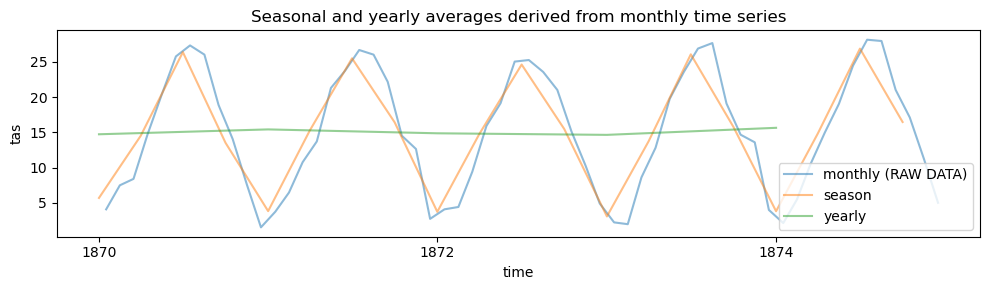

In [12]:
# plot time series of temporal averages for a specific grid point: seasonal and yearly averages derived from monthly time series
lat_point = 30
lon_point = 120

start_year = "1870-01-01"
end_year = "1874-12-31"

plt.figure(figsize=(10, 3))
ax = plt.subplot()

ds.tas.sel(lat=lat_point, lon=lon_point, time=slice(start_year, end_year)).plot(
    ax=ax, label="monthly (RAW DATA)", alpha=0.5
)
ds_season.tas.sel(lat=lat_point, lon=lon_point, time=slice(start_year, end_year)).plot(
    ax=ax, label="season", alpha=0.5
)
ds_yearly.tas.sel(lat=lat_point, lon=lon_point, time=slice(start_year, end_year)).plot(
    ax=ax, label="yearly", alpha=0.5
)

plt.title("Seasonal and yearly averages derived from monthly time series")

plt.legend()
plt.tight_layout()

### Monthly Averages

**Group time coordinates by year and month**

For this example, we will be loading a subset of 3-hourly time series data for `tas`.


In [13]:
ds2 = xc.tutorial.open_dataset("tas_3hr_access", add_bounds="T", cache=False)

# Unit adjust (-273.15, K to C)
ds2["tas"] = ds2.tas - 273.15

ds2

<xarray.Dataset> Size: 25MB
Dimensions:    (lat: 25, bnds: 2, lon: 17, time: 14608)
Coordinates:
  * lat        (lat) float64 200B 15.0 16.25 17.5 18.75 ... 42.5 43.75 45.0
  * lon        (lon) float64 136B 15.0 16.88 18.75 20.62 ... 41.25 43.12 45.0
    height     float64 8B 2.0
  * time       (time) object 117kB 2010-01-01 03:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 400B 14.38 15.62 15.62 ... 44.38 44.38 45.62
    lon_bnds   (lon, bnds) float64 272B 14.06 15.94 15.94 ... 44.06 44.06 45.94
    tas        (time, lat, lon) float32 25MB 12.32 13.32 14.73 ... 0.9856 1.557
    time_bnds  (time, bnds) object 234kB 2010-01-01 03:00:00 ... 2015-01-01 0...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  87658.0
    creation_date:          2020-06-05T04:54:56Z
    ...                     ...
    variable_id:            tas
    variant_label:          r10i1p1f1
    version:                v20200605
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b79e6a05-c482-46cf-b3b8-83b9a7d0cfdd

In [14]:
ds2_monthly_avg = ds2.temporal.group_average("tas", freq="month", weighted=True)

In [15]:
ds2_monthly_avg.tas

<xarray.DataArray 'tas' (time: 61, lat: 25, lon: 17)> Size: 207kB
array([[[ 1.61786594e+01,  1.74559097e+01,  1.94480495e+01, ...,
          2.34645004e+01,  2.18754005e+01,  1.79806404e+01],
        [ 1.45729771e+01,  1.55177536e+01,  1.72276688e+01, ...,
          2.46986790e+01,  2.18389759e+01,  1.73648300e+01],
        [ 1.44537239e+01,  1.50582619e+01,  1.52067757e+01, ...,
          2.41571884e+01,  1.97343559e+01,  1.60722790e+01],
        ...,
        [ 6.54183483e+00,  6.79240608e+00,  1.70920479e+00, ...,
         -4.98785925e+00, -3.88630557e+00, -4.23007584e+00],
        [ 5.03322697e+00, -1.54658580e+00, -4.95725536e+00, ...,
         -5.16553450e+00, -5.44478226e+00, -6.29251814e+00],
        [ 5.49827933e-01, -5.47259855e+00, -5.97103596e+00, ...,
         -6.76723289e+00, -7.27683926e+00, -7.55593681e+00]],

       [[ 1.98130493e+01,  2.09146328e+01,  2.23248081e+01, ...,
          2.32238827e+01,  2.23396301e+01,  1.94749165e+01],
        [ 1.81694736e+01,  1.90156555e+01,  2.01379032e+01, ...,
          2.40488434e+01,  2.21553459e+01,  1.91551342e+01],
        [ 1.80113373e+01,  1.85423183e+01,  1.82385426e+01, ...,
          2.35794964e+01,  2.11200123e+01,  1.77968540e+01],
...
        [ 1.31856813e+01,  1.29353800e+01,  8.61762810e+00, ...,
          7.43787110e-01, -1.52637288e-01, -2.79423833e-01],
        [ 1.20628519e+01,  6.12488794e+00,  2.79707456e+00, ...,
          5.57704985e-01,  4.26104307e-01, -2.85036471e-02],
        [ 7.79992199e+00,  2.31169987e+00,  2.05793524e+00, ...,
          2.48682663e-01, -1.95361272e-01,  2.31985487e-02]],

       [[ 1.31428223e+01,  1.46885071e+01,  1.60330200e+01, ...,
          2.31875916e+01,  1.99918518e+01,  1.19972229e+01],
        [ 1.14890747e+01,  1.29200134e+01,  1.49679260e+01, ...,
          2.50103455e+01,  1.80541687e+01,  9.75668335e+00],
        [ 1.14260254e+01,  1.21452637e+01,  1.26150208e+01, ...,
          2.61590271e+01,  1.39296875e+01,  6.50259399e+00],
        ...,
        [ 1.32025146e+01,  1.30453796e+01,  7.18066406e+00, ...,
          2.14541626e+00,  5.86517334e-01,  1.69454956e+00],
        [ 1.25014343e+01,  7.12692261e+00,  3.98294067e+00, ...,
          9.45831299e-01,  3.03814697e+00,  8.63220215e-01],
        [ 8.37417603e+00,  2.83789062e+00,  1.30761719e+00, ...,
          3.08517456e+00,  9.85595703e-01,  1.55654907e+00]]])
Coordinates:
  * lat      (lat) float64 200B 15.0 16.25 17.5 18.75 ... 41.25 42.5 43.75 45.0
  * lon      (lon) float64 136B 15.0 16.88 18.75 20.62 ... 41.25 43.12 45.0
    height   float64 8B 2.0
  * time     (time) object 488B 2010-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       group_average
    freq:       month
    weighted:   True

### Daily Averages

**Group time coordinates by year, month, and day**

We will use the resampled 3-hourly data once again.


In [16]:
ds3_day_avg = ds2.temporal.group_average("tas", freq="day", weighted=True)

In [17]:
ds3_day_avg.tas

<xarray.DataArray 'tas' (time: 1827, lat: 25, lon: 17)> Size: 6MB
array([[[16.81538582, 18.05098152, 19.78987885, ..., 23.58581161,
         21.99581909, 17.25448608],
        [14.93829823, 16.25762939, 18.38165665, ..., 24.6938858 ,
         19.36546135, 14.32250881],
        [14.60255241, 15.39885139, 16.55115509, ..., 24.55134392,
         16.31100082,  7.84569407],
        ...,
        [ 8.8386097 , 11.32649899,  7.58696175, ..., -8.78603172,
         -5.8878088 , -4.24894953],
        [ 7.15283585,  1.43564284, -1.1071341 , ..., -8.74791622,
         -5.04599857, -3.26600432],
        [ 1.71053219, -6.45468092, -6.78268862, ..., -6.33603764,
         -3.46351838, -3.35134888]],

       [[16.98338699, 18.74590683, 20.51192093, ..., 23.65264511,
         21.67049026, 17.48049164],
        [14.85002136, 16.50365448, 18.55603027, ..., 24.99718857,
         19.97584152, 15.26877975],
        [14.40544891, 15.13078308, 16.06568909, ..., 24.64564514,
         16.06109238, 10.25662613],
...
        [12.76204681, 12.85602951,  8.02008438, ...,  2.16846848,
          0.75373077,  1.78427124],
        [12.5476799 ,  7.40015411,  5.36021805, ...,  1.0058136 ,
          2.98559952,  2.5796814 ],
        [ 8.93581009,  5.72495651,  5.07324219, ...,  2.71203232,
          1.42546463,  1.95752716]],

       [[13.14282227, 14.68850708, 16.03302002, ..., 23.18759155,
         19.99185181, 11.9972229 ],
        [11.48907471, 12.92001343, 14.96792603, ..., 25.01034546,
         18.0541687 ,  9.75668335],
        [11.42602539, 12.14526367, 12.61502075, ..., 26.1590271 ,
         13.9296875 ,  6.50259399],
        ...,
        [13.20251465, 13.04537964,  7.18066406, ...,  2.14541626,
          0.58651733,  1.69454956],
        [12.50143433,  7.12692261,  3.98294067, ...,  0.9458313 ,
          3.03814697,  0.86322021],
        [ 8.37417603,  2.83789062,  1.30761719, ...,  3.08517456,
          0.9855957 ,  1.55654907]]])
Coordinates:
  * lat      (lat) float64 200B 15.0 16.25 17.5 18.75 ... 41.25 42.5 43.75 45.0
  * lon      (lon) float64 136B 15.0 16.88 18.75 20.62 ... 41.25 43.12 45.0
    height   float64 8B 2.0
  * time     (time) object 15kB 2010-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       group_average
    freq:       day
    weighted:   True

#### Visualize averages derived from 3-hourly data on a specific point


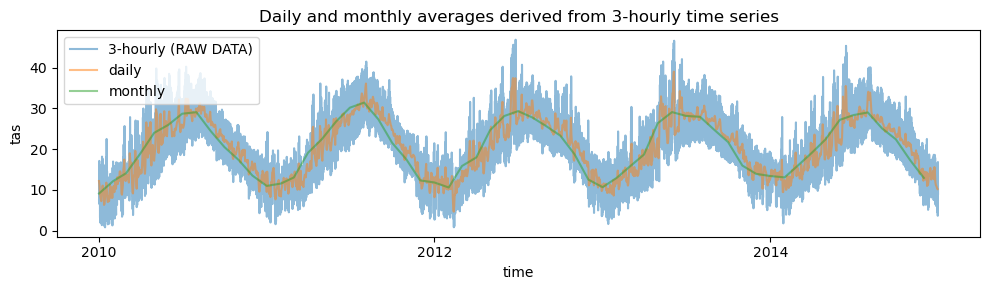

In [18]:
# plot time series of temporal averages for a specific grid point: daily and monthly averages derived from 3-hourly time series
lat_point = 30
lon_point = 30

start_year = "2010-01-01"
end_year = "2014-12-31"

plt.figure(figsize=(10, 3))
ax = plt.subplot()

ds2.tas.sel(lat=lat_point, lon=lon_point, time=slice(start_year, end_year)).plot(
    ax=ax, label="3-hourly (RAW DATA)", alpha=0.5
)
ds3_day_avg.tas.sel(
    lat=lat_point, lon=lon_point, time=slice(start_year, end_year)
).plot(ax=ax, label="daily", alpha=0.5)
ds2_monthly_avg.tas.sel(
    lat=lat_point, lon=lon_point, time=slice(start_year, end_year)
).plot(ax=ax, label="monthly", alpha=0.5)

plt.title("Daily and monthly averages derived from 3-hourly time series")
plt.legend()
plt.tight_layout()